#### IMPORTING LIBRARYS


In [1]:
import time 
start=time.time()
import pandas as pd 
import numpy as np 
import seaborn as sns  
import nltk 
from nltk  import FreqDist,pos_tag
from random import randint 
#nltk.download('stopwords')
from nltk.corpus import stopwords,wordnet
import matplotlib.pyplot as plt  
from wordcloud import STOPWORDS,WordCloud  
from matplotlib import rcParams
from nltk.tokenize import sent_tokenize, word_tokenize  
from nltk.stem.snowball import SnowballStemmer  
from nltk.stem import WordNetLemmatizer   
import spacy
from spacy import displacy  
from statistics import mode 
import  string as String  
from sklearn.datasets import load_linnerud
from sklearn.model_selection import cross_val_predict,cross_val_score,train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression 
from sklearn.datasets import load_diabetes 
from sklearn.decomposition import PCA  
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.neighbors import RadiusNeighborsRegressor 
from sklearn.cross_decomposition import PLSCanonical,PLSRegression
from sklearn.ensemble import ExtraTreesRegressor 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor  
from sklearn.multioutput import MultiOutputRegressor,MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer 
from sklearn.metrics import r2_score,confusion_matrix,ConfusionMatrixDisplay
from tqdm import tqdm 
import re as re

In [2]:
df_linerud=load_linnerud(as_frame=True) 
df_linerud['data']

,Chins,Situps,Jumps
0,5.0,162.0,60.0
1,2.0,110.0,60.0
2,12.0,101.0,101.0
3,12.0,105.0,37.0
4,13.0,155.0,58.0
5,4.0,101.0,42.0
6,8.0,101.0,38.0
7,6.0,125.0,40.0
8,15.0,200.0,40.0
9,17.0,251.0,250.0


In [3]:
df_relevant=pd.read_csv("./relevant/relevant.csv")

#### LOADING AND PREPARING DATA

In [4]:

df_train=pd.read_csv("./data/train.csv") 
df_essays=pd.DataFrame(df_train["full_text"])
df_test=pd.read_csv("./data/test.csv")   
y=df_train.drop(["text_id","full_text"],axis=1)  
essays=df_essays["full_text"]
essays=list(essays) 
essays=" ".join(essays)  
essays=('''"""''') +essays + ('''"""''')   
target_names=list(y)
df_train

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5


## GLOBAL FUNCTIONS

In [5]:
english_words=[] 
file=open("./data/actual_all_words.txt","r")  
wfile=file.readlines() 
for word in wfile: 
    english_words.append(word.lower()) 
for i in range(0,len(english_words)):  
    english_words[i]=english_words[i].replace("\n","")    
NER = spacy.load("en_core_web_sm")     

In [6]:
unwanted_list=["'s","`s","´s","'re","`re","´re","n't","n´t","n`t","'ll","´ll","`ll","'d","´d","`d","'ve","`ve","´ve","'m","`m","´m","'",'"',".",",","`","!","?","´",':',"(",")","/",";",'#']
unwanted_list.extend(list(String.punctuation)) 
unwanted_list=list(set(unwanted_list))
stop_words=stopwords.words("english")     
load_model = spacy.load('en_core_web_sm', disable = ['parser','ner']) 
load_model.max_length =len(essays) *2
def remove_unwanted(string,unwanted):  
    for i in unwanted:  
        if i == "'s" or i== '`s' or i == '´s':   
            if "let's" in string or "let´s" in string or "let`s" in string:
                string=string.replace("let's","lets")
                string=string.replace("let´s","lets")
                string=string.replace("let`s","lets")
            string=string.replace(i," is") 
        elif i == "'re" or i== '`re' or i == '´re': 
            string=string.replace(i," are") 
        elif i== "n't" or i == "n`t" or i== "n´t":  
            if "won't" in string or "won´t" in string or "won`t" in string:
                string=string.replace("won`t","wont")
                string=string.replace("won´t","wont")
                string=string.replace("won't","wont")
            string=string.replace(i," will not")   
        elif i == "'ll" or i == "´ll" or i == "`ll": 
            string=string.replace(i," will") 
        elif i == "'d" or i == "´d" or i == "`d": 
            string=string.replace(i," would")
        elif i == "'ve" or i == "´ve" or i == "`ve": 
            string=string.replace(i," have") 
        elif i == "'m" or i == "´m" or i == "`m": 
            string=string.replace(i," am") 
        else:
            string=string.replace(i," ")
    return string    
def filter_text(string,stop_words=stop_words,unique_words=False,filter_by_sw=True,remove_numbers=False,remove_numbers_and_words_glued=False): 
    string=remove_unwanted(string,unwanted_list)  
    if remove_numbers: 
        string=removing_numbers(string) 
    if remove_numbers_and_words_glued: 
        string=removing_numbers(string,remove_text_next_to_num=True)
    tokenized=word_tokenize(string) 
    filtered=tuple(tokenized)
    if filter_by_sw:
        filtered=tuple([word.casefold() for word in tokenized if word.casefold() not in stop_words])
    if unique_words:
        filtered =tuple(set(filtered))
    return filtered 
def get_num_words(string,unique_words=True,filter_by_sw=True):  
    filtered=filter_text(string,unique_words=unique_words,filter_by_sw=filter_by_sw)
    return len(filtered)
def makeWordcloud(text,stopwords=STOPWORDS,maxwords=300,width=800,height=800,color="black",column="fulltext"): 
    if isinstance(text,pd.core.frame.DataFrame):  
        newtext="\n".join(text[column])
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()  
    elif isinstance(text,str):  
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()
    elif isinstance(text,list) or isinstance(text,np.ndarray) or isinstance(text,pd.core.series.Series): 
        newtext=" ".join(text)
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()  
def create_txt_with_example(specific=randint(0,len(df_train["full_text"]))): 
    newExample=open("./examples/example_%d.txt" % specific,"w") 
    newExample.write(df_train["full_text"][specific]) 
    newExample.close()  
def getcommonwords(text,amount=10):  
    filtered=filter_text(text,unique_words=False) 
    freq=FreqDist(filtered) 
    return tuple([word[0] for word in freq.most_common(amount)]) 
def pos_tag_text(text,filter=False,to_dic=False): 
    tagged=pos_tag(text) 
    return tagged
def mistakeCounter(essay): 
    filtered_text=filter_text(essay,filter_by_sw=False,unique_words=False)  
    a=[]
    for word in filtered_text: 
        if word.lower() not in english_words:  
           a.append(word)   
    NerText=NER(" ".join(a)) 
    for word in NerText.ents: 
        if word.label_ == "PERSON" or word.label_ == "ORG" or word.label_ == "LOC" or word.label_ == "DATE" or word.label_ == "MONEY"   or word.label_ == "PRODUCT" or word.label_ == "WORK_OF_ART" or word.label_ == "FAC" or word.label_ == "EVENT" or word.label_ == "GPE" or  word.label_ == "TIME" or  word.label_ == "PERCENT" or word.label_ == "NORP" :
            words=word_tokenize(word.text) 
            for j in words:  
                if j in a:
                    a.remove(j)
    final=a 
    return len(final)   
def mistakelist(essay):  
    filtered_text=filter_text(essay,filter_by_sw=False,unique_words=False)  
    a=[]
    for word in filtered_text: 
        if word.lower() not in english_words:  
           a.append(word)   
    NerText=NER(" ".join(a)) 
    for word in NerText.ents: 
        if word.label_ == "PERSON" or word.label_ == "ORG" or word.label_ == "LOC" or word.label_ == "DATE" or word.label_ == "MONEY"   or word.label_ == "PRODUCT" or word.label_ == "WORK_OF_ART" or word.label_ == "FAC" or word.label_ == "EVENT" or word.label_ == "GPE" or  word.label_ == "TIME" or  word.label_ == "PERCENT" or word.label_ == "NORP" :
            words=word_tokenize(word.text) 
            for j in words:  
                if j in a:
                    a.remove(j)
    final=a 
    return final 
def getradicals(essay): 
    doc=load_model(" ".join(filter_text(essay,unique_words=False))) 
    radicals=[token.lemma_ for token in doc] 
    final=radicals
    for word in radicals:
        if word not in english_words:
            if word in final: 
                final.remove(word)
    return final  
def amountRadicals(essay): 
    radicals=set(getradicals(essay))
    return len(radicals) 
def stop_words_counter(essay): 
    filtered=filter_text(essay,unique_words=False,filter_by_sw=False)  
    a=[]
    for word in filtered: 
        if word.lower() in stop_words: 
            a.append(word.lower()) 
    return len(a);  
def transform_to_bag_of_words(essay): 
    vectorizer=CountVectorizer(tokenizer=lambda text : filter_text(text,unique_words=False,filter_by_sw=True,remove_numbers_and_words_glued=True),stop_words=stop_words,max_features=6000) 
    if isinstance(essay,pd.core.frame.DataFrame)or isinstance(essay,pd.core.series.Series) :   
        bag=vectorizer.fit_transform(df_essays["full_text"]).toarray() 
        essay=[subarray for subarray in bag] 
        new_cols=df_relevant.iloc[:,8:].copy() 
        for i in new_cols.columns:  
            if i != "most_common_words":
                bag=np.c_[bag,df_relevant[i]]
        return bag,vectorizer.get_feature_names_out()
    elif isinstance(essay,list):
        bag=vectorizer.fit_transform(df_essays["full_text"]).toarray() 
        essay=[subarray for subarray in bag] 
        return bag,vectorizer.get_feature_names_out()
    else: 
        bag=vectorizer.fit_transform(filter_text(essay,unique_words=False)) 
        return bag,vectorizer.get_feature_names_out() 
def removing_numbers(essay,remove_text_next_to_num=False): 
    newessay=""
    if(remove_text_next_to_num): 
        newessay=re.sub(r"\d\w* | [\s]+ |\d+" ,"",essay) 
    else:
        newessay=re.sub(r"\d*" ,"",essay) 
    return newessay

In [7]:
df_relevant

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_of_words,most_common_words,ort_mistakes,amt_radicals,amt_stopwords
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,129,"('students', 'go', 'home', 'u', 'wont', 'get',...",1,81,135
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,215,"('change', 'different', 'see', 'understand', '...",0,80,323
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,133,"('average', 'sports', 'school', 'activities', ...",0,56,202
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,282,"('make', 'choices', 'others', 'want', 'people'...",0,125,484
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,112,"('people', 'act', 'change', 'kindess', 'person...",10,58,122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,96,"('believe', 'could', 'using', 'cellphones', 'u...",16,56,83
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,214,"('students', 'work', 'group', 'working', 'get'...",15,98,253
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0,109,"('problem', 'best', 'every', 'get', 'chance', ...",9,59,150
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5,228,"('people', 'others', 'example', 'influence', '...",1,94,294


## CREATE AN EXAMPLE txt

In [8]:
#create_txt_with_example()   

## ADDING RELEVANT INFORMATION

### MAKING RELEVANT FILE

In [9]:
#df_relevant=df_train   
#df_relevant=pd.read_csv("./relevant/relevant.csv")

### guide to pos_tag

In [10]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

### GUIDE TO NER

In [11]:
NER.get_pipe('ner').labels  

('CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART')

### ADDING NUMBER OF WORDS PER ESSAY

In [12]:
""" df_train["full_text"]
e_string=df_essays["full_text"][300]
df_relevant["n_of_words"]=[get_num_words(essay,unique_words=False) for essay in df_train["full_text"]] 
df_relevant """

' df_train["full_text"]\ne_string=df_essays["full_text"][300]\ndf_relevant["n_of_words"]=[get_num_words(essay,unique_words=False) for essay in df_train["full_text"]] \ndf_relevant '

### ADDING 10 MOST COMMON WORDS OF EACH ESSAY

In [13]:
""" df_relevant["most_common_words"]=[getcommonwords(essay,10) for essay in df_essays["full_text"]]  
df_relevant """

' df_relevant["most_common_words"]=[getcommonwords(essay,10) for essay in df_essays["full_text"]]  \ndf_relevant '

### ADDING HOW MANY ORTOGRAPHY ERRORS

In [14]:
""" df_relevant["ort_mistakes"]=[mistakeCounter(essay) for essay in df_train["full_text"]] 
df_relevant      """

' df_relevant["ort_mistakes"]=[mistakeCounter(essay) for essay in df_train["full_text"]] \ndf_relevant      '

### GETTING RADICALS

In [15]:
""" df_relevant["amt_radicals"]=[amountRadicals(essay) for essay in df_train["full_text"]] 
df_relevant """

' df_relevant["amt_radicals"]=[amountRadicals(essay) for essay in df_train["full_text"]] \ndf_relevant '

### ADDING NUM OF STOPWORDS

In [16]:
""" df_relevant["amt_stopwords"]=[stop_words_counter(essay) for essay in df_train["full_text"]] 
df_relevant """

' df_relevant["amt_stopwords"]=[stop_words_counter(essay) for essay in df_train["full_text"]] \ndf_relevant '

## TESTING

In [17]:
arnaldo=filter_text(essays,unique_words=False) 

In [18]:
bags,colnames=transform_to_bag_of_words(["""Penny Lane, there is a barber showing photographs Of every head he's had the pleasure to know And all the people that come and go Stop and say, "Hello" On the corner is a banker with a motorcar And little children laugh at him behind his back And the banker never wears a Mac in the pouring rain Very strange Penny Lane is in my ears and in my eyes Wet beneath the blue suburban skies I sit and meanwhile back in Penny Lane, there is a fireman with an hourglass And in his pocket is a portrait of the Queen He likes to keep his fire engine clean It's a clean machine Penny Lane, is in my ears and in my eyes A four of fish and finger pies In summer, meanwhile back Behind the shelter in the middle of a roundabout A pretty nurse is selling poppies from a tray And though she feels as if she's in a play She is anyway Penny Lane, the barber shaves another customer We see the banker sitting waiting for a trim And then, the fireman rushes in from the pouring rain Very strange Penny Lane is in my ears and in my eyes There beneath the blue suburban skies I sit and meanwhile back Penny Lane is in my ears and in my eyes There beneath the blue suburban skies Penny Lane""","""Coming to you on a dusty road Good loving, I got a truck load And when you get it, you got something Don't worry, 'cause I'm coming I'm a soul man I'm a soul man I'm a soul man (come on!) I'm a soul man And that ain't all Got what I got the hard way And I make it better, each and every day So honey, said don't you fret 'Cause you ain't seen nothing yet I'm a soul man I'm a soul man I'm a soul man I'm a soul man, oh I was brought up on a side street, yes mam I learned how to love before I could eat I was educated at woodstock When I start loving, oh I can't stop I'm a soul man I'm a soul man I'm a soul man (yeah!) I'm a soul man Just grab the rope and I'll pull you in Give you hope and be your only boyfriend Yeah, yeah, yeah, yeah (yeah!) I'm talking about a soul man I'm a soul man (And you're a) soul man Soul man (oh lord) Soul man (I'm a) soul man (And you're a) soul man (And you're a) soul man""","""Hello? Is there anybody in there? Just nod if you can hear me Is there anyone home? Come on now I hear you're feeling down Well, I can ease your pain And get you on your feet again Relax I'll need some information first Just the basic facts Can you show me where it hurts? There is no pain, you are receding A distant ship, smoke on the horizon You are only coming through in waves Your lips move, but I can't hear what you're saying When I was a child, I had a fever My hands felt just like two balloons Now I've got that feeling once again I can't explain, you would not understand This is not how I am I have become comfortably numb I have become comfortably numb Okay Just a little pinprick There'll be no more But you may feel a little sick Can you stand up? I do believe it's working, good That'll keep you going through the show Come on, it's time to go There is no pain, you are receding A distant ship, smoke on the horizon You are only coming through in waves Your lips move, but I can't hear what you're saying When I was a child, I caught a fleeting glimpse Out of the corner of my eye I turned to look, but it was gone I cannot put my finger on it now The child is grown, the dream is gone I have become comfortably numb"""])
pd.DataFrame(bags,columns=colnames)

c:\Users\Leonardo\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'wont', 'would'] not in stop_words.
  warnings.warn(


,abandoned,abilities,ability,able,abole,aboute,abraham,abroad,absent,absolute,...,youself,youth,youtube,youve,youyou,ypu,yuo,zero,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3907,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
bags.shape

(3911, 6000)

In [20]:
""" e_string=""  
letters=list(String.ascii_letters)
points=list(String.punctuation)
for i in range(0,500):  
    max=1000
    limiter=randint(0,max)
    e_string += str(randint(0,654)) 
    while(limiter > 500): 
        decider=randint(0,1) 
        if decider == 0: 
            e_string += letters[randint(0,len(letters)-1)]
        limiter=randint(0,max*0.8)
    e_string += " " 
for i in letters: 
    e_string +=" " +i 
removing_numbers(e_string,remove_text_next_to_num=True)  """

' e_string=""  \nletters=list(String.ascii_letters)\npoints=list(String.punctuation)\nfor i in range(0,500):  \n    max=1000\n    limiter=randint(0,max)\n    e_string += str(randint(0,654)) \n    while(limiter > 500): \n        decider=randint(0,1) \n        if decider == 0: \n            e_string += letters[randint(0,len(letters)-1)]\n        limiter=randint(0,max*0.8)\n    e_string += " " \nfor i in letters: \n    e_string +=" " +i \nremoving_numbers(e_string,remove_text_next_to_num=True)  '

In [21]:
vectorizer=CountVectorizer(tokenizer=lambda text : filter_text(text,unique_words=False,filter_by_sw=True,remove_numbers_and_words_glued=True),stop_words=stop_words,max_features=6000) 
bag=vectorizer.fit_transform(df_essays["full_text"]).toarray() 
first=pd.DataFrame(bag,columns=vectorizer.get_feature_names_out()) 
first

c:\Users\Leonardo\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'wont', 'would'] not in stop_words.
  warnings.warn(


,abandoned,abilities,ability,able,abole,aboute,abraham,abroad,absent,absolute,...,youself,youth,youtube,youve,youyou,ypu,yuo,zero,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3907,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## VISUALIZING DATA 

### SEEING REGULAR WORD CLOUD

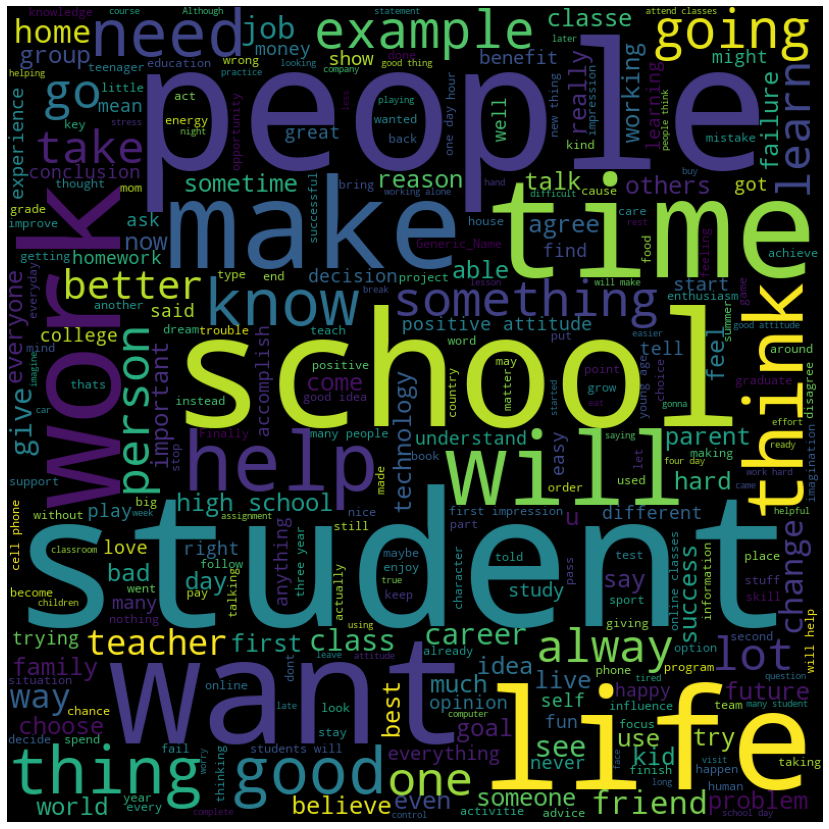

In [22]:
makeWordcloud(essays) 

### SEEING WORDCLOUD OF RADICALS

In [23]:
#radicals=getradicals(essays)

In [24]:
#makeWordcloud(" ".join(radicals)) 

### SEEING MOST COMMON WORDS FREQUENCY

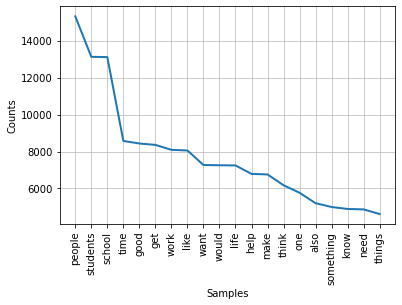

In [25]:
filtered_words=filter_text(essays,unique_words=False) 
common=FreqDist(filtered_words)
common.plot(20) 
plt.show()

### SEEING HISTOGRAM OF EACH TARGET

dimX:2 dimY:3
0
1
2
3
4
5


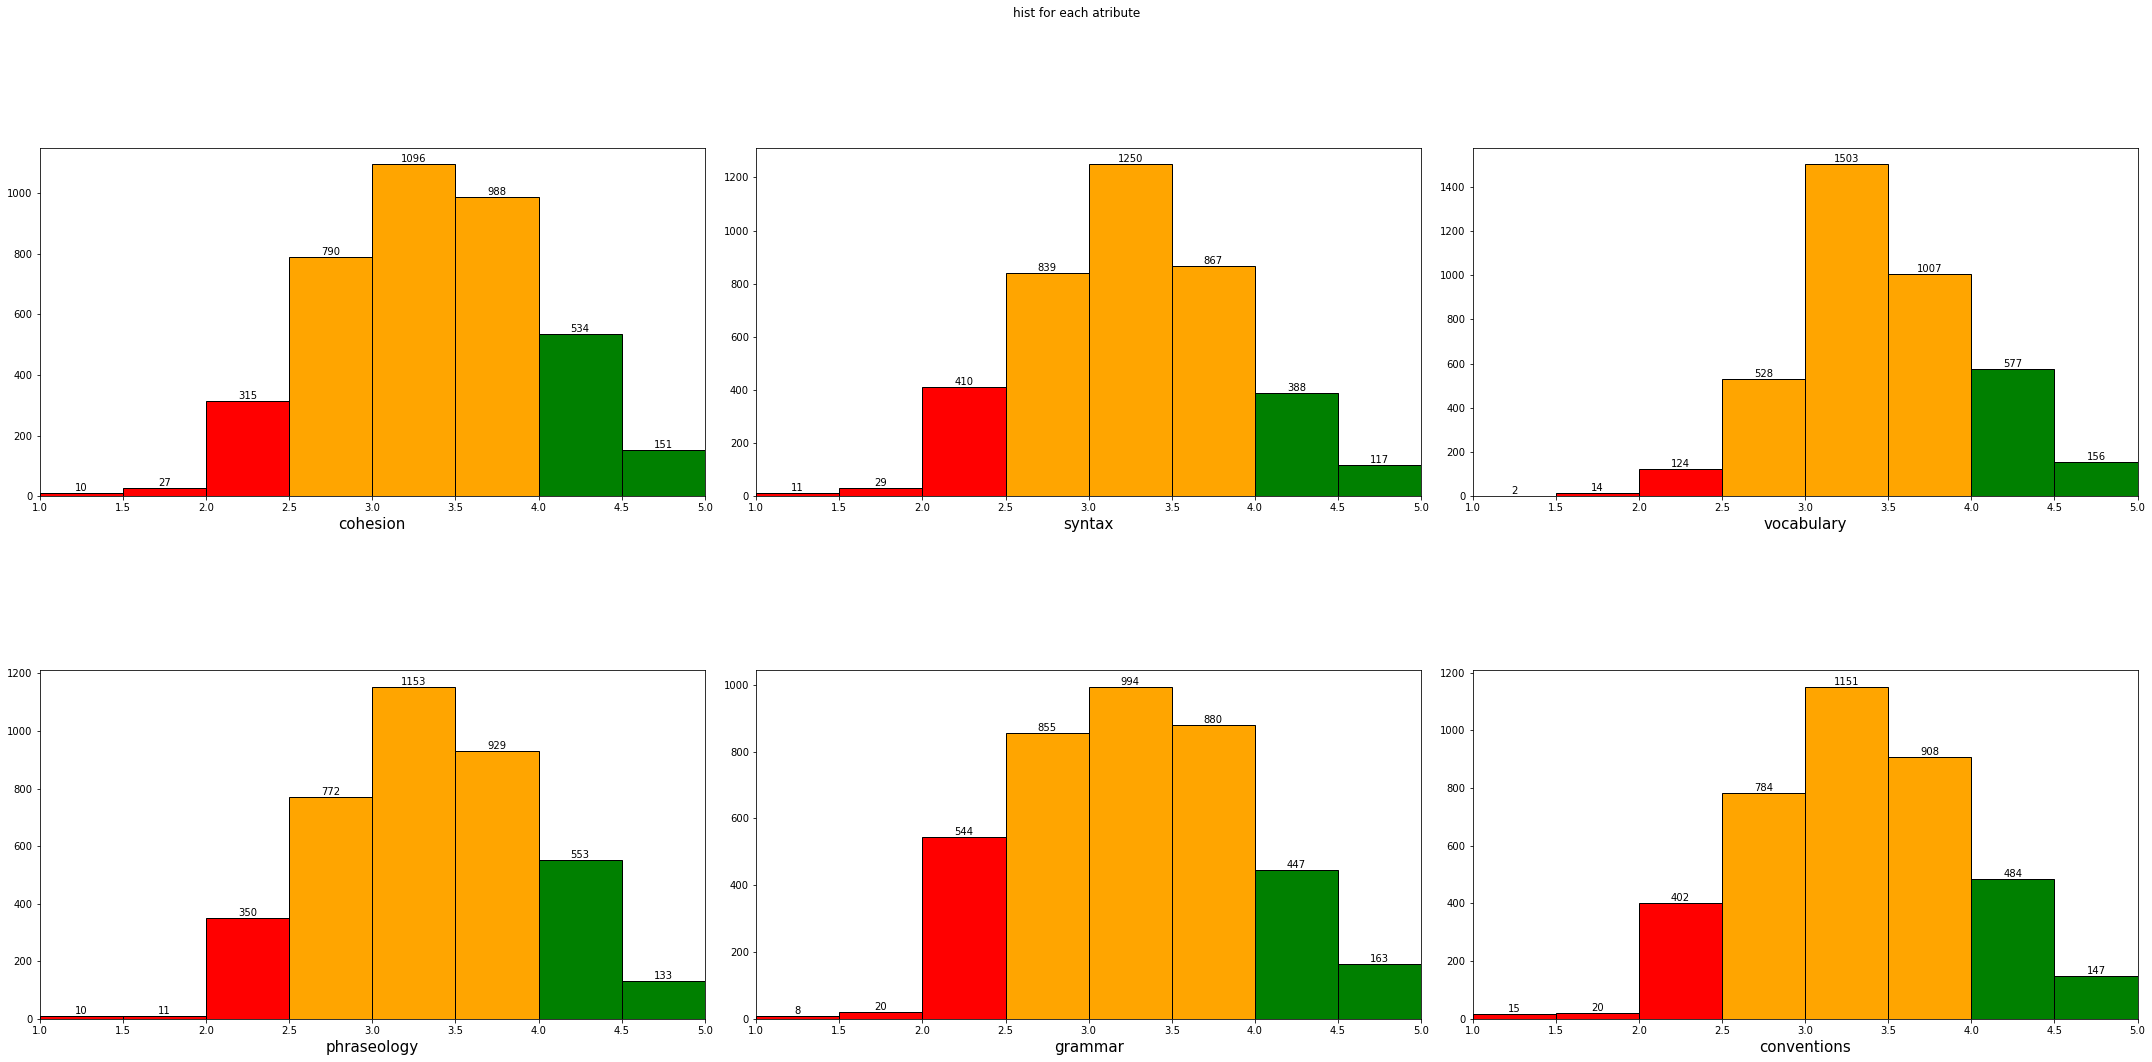

In [26]:

fig,ax =plt.subplots(2,3) 
fig.suptitle("hist for each atribute")   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]     
print("dimX:%d dimY:%d" % (dimX,dimY))
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimY)+j 
        print(oneDIndex)
        N, bins, patches=ax[i,j].hist(y[target_names[oneDIndex]],edgecolor="black",bins=8)   
        for k in range(0,3):
            patches[k].set_facecolor("red") 
        for k in range(3,6): 
            patches[k].set_facecolor("orange")
        for k in range(6,len(patches)):  
            patches[k].set_facecolor("green")
        ax[i,j].bar_label(patches)
        ax[i,j].set_xlabel(target_names[oneDIndex],size=15)  
        ax[i,j].set_xbound(lower=1.0,upper=5.0)
fig.align_labels() 
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5)  

### MAKING HIST OF MISTAKES

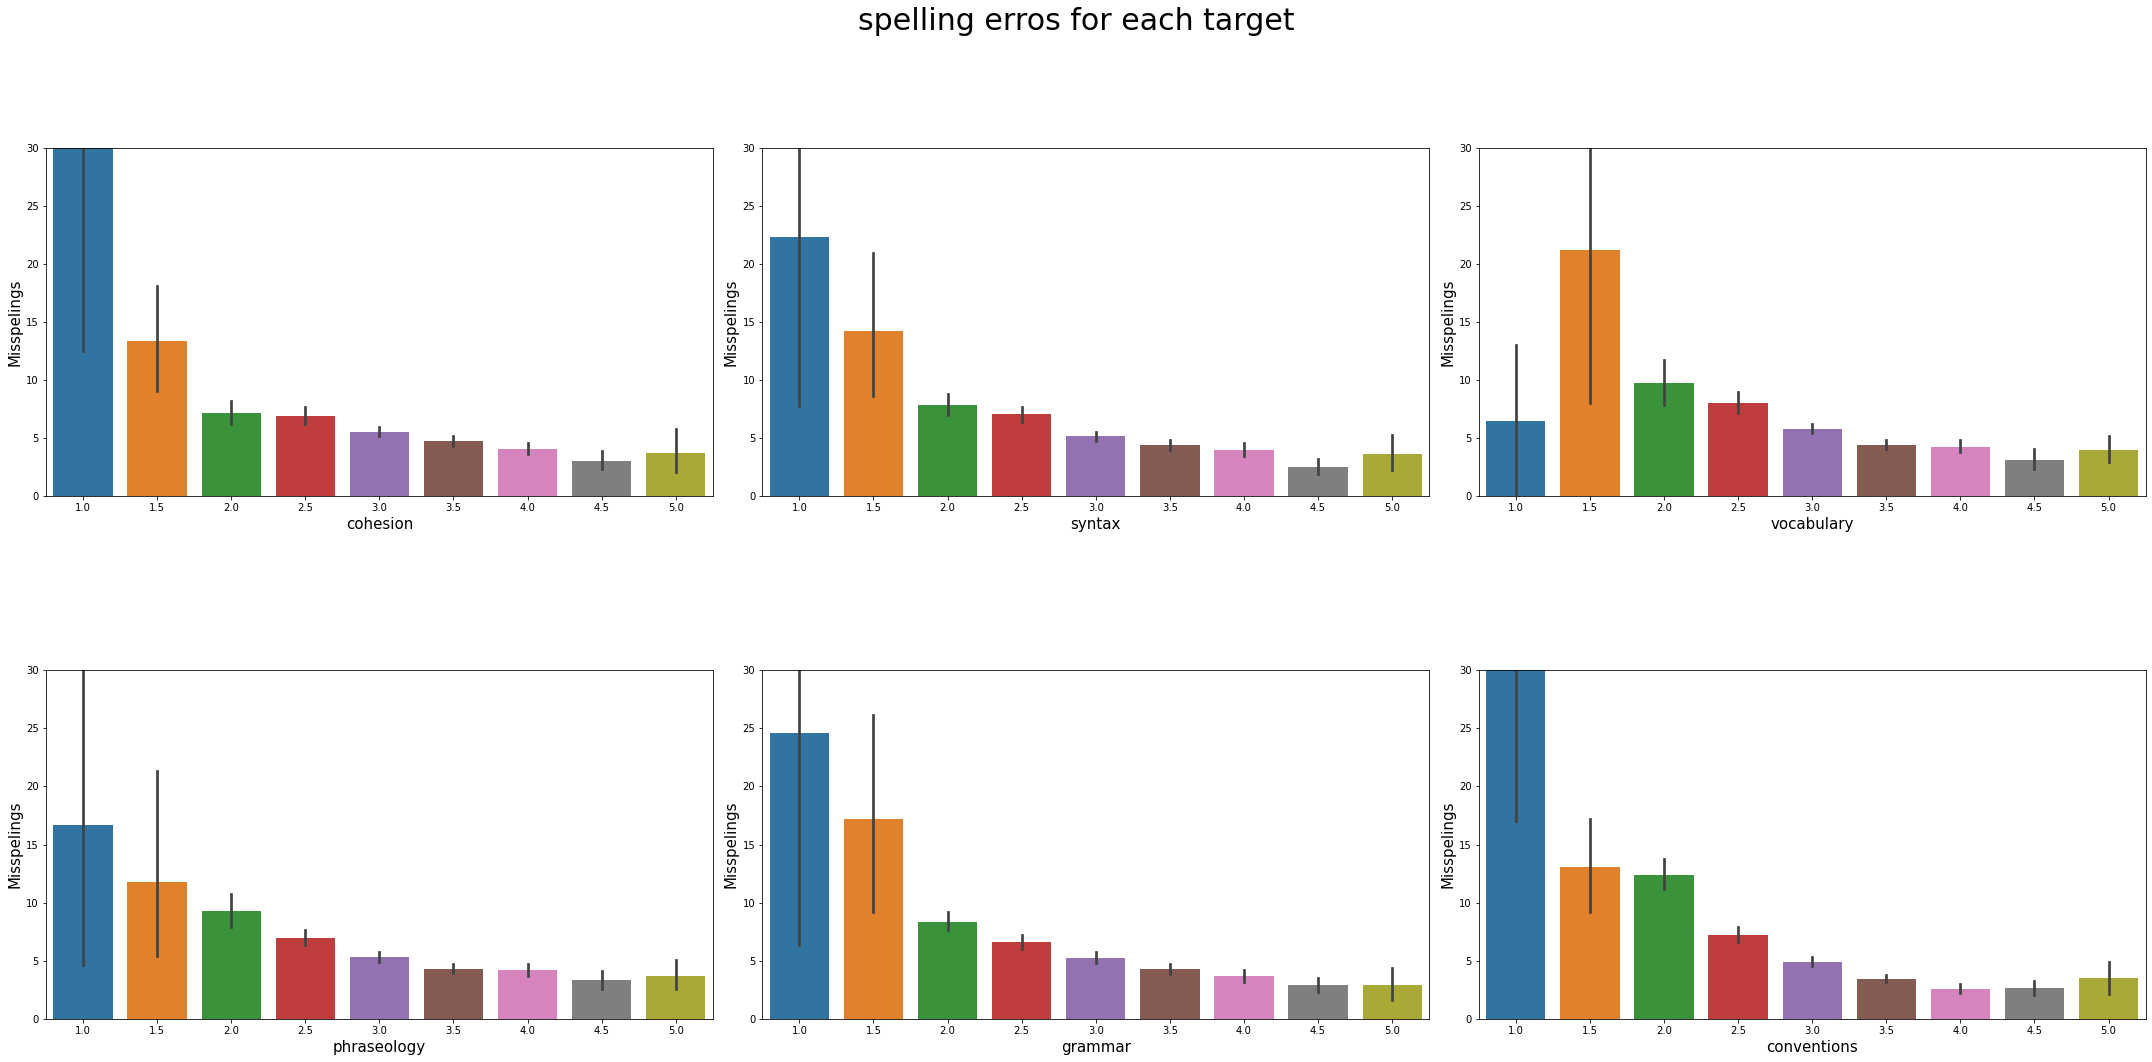

In [27]:
fig,ax =plt.subplots(2,3) 
fig.suptitle("spelling erros for each target",fontsize=30)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]    
target_names=list(y)
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimY)+j
        graph=sns.barplot(data=df_relevant,x=target_names[oneDIndex],y="ort_mistakes",ax=ax[i,j])
        ax[i,j].set_xlabel(target_names[oneDIndex],size=15) 
        ax[i,j].set_ylabel("Misspelings",size=15) 
        ax[i,j].set_ylim(0,30)
fig.align_labels() 
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5)  

#sns.barplot(data=df_relevant,x="grammar",y="ort_mistakes")

### MAKING HIST OF RADICALS

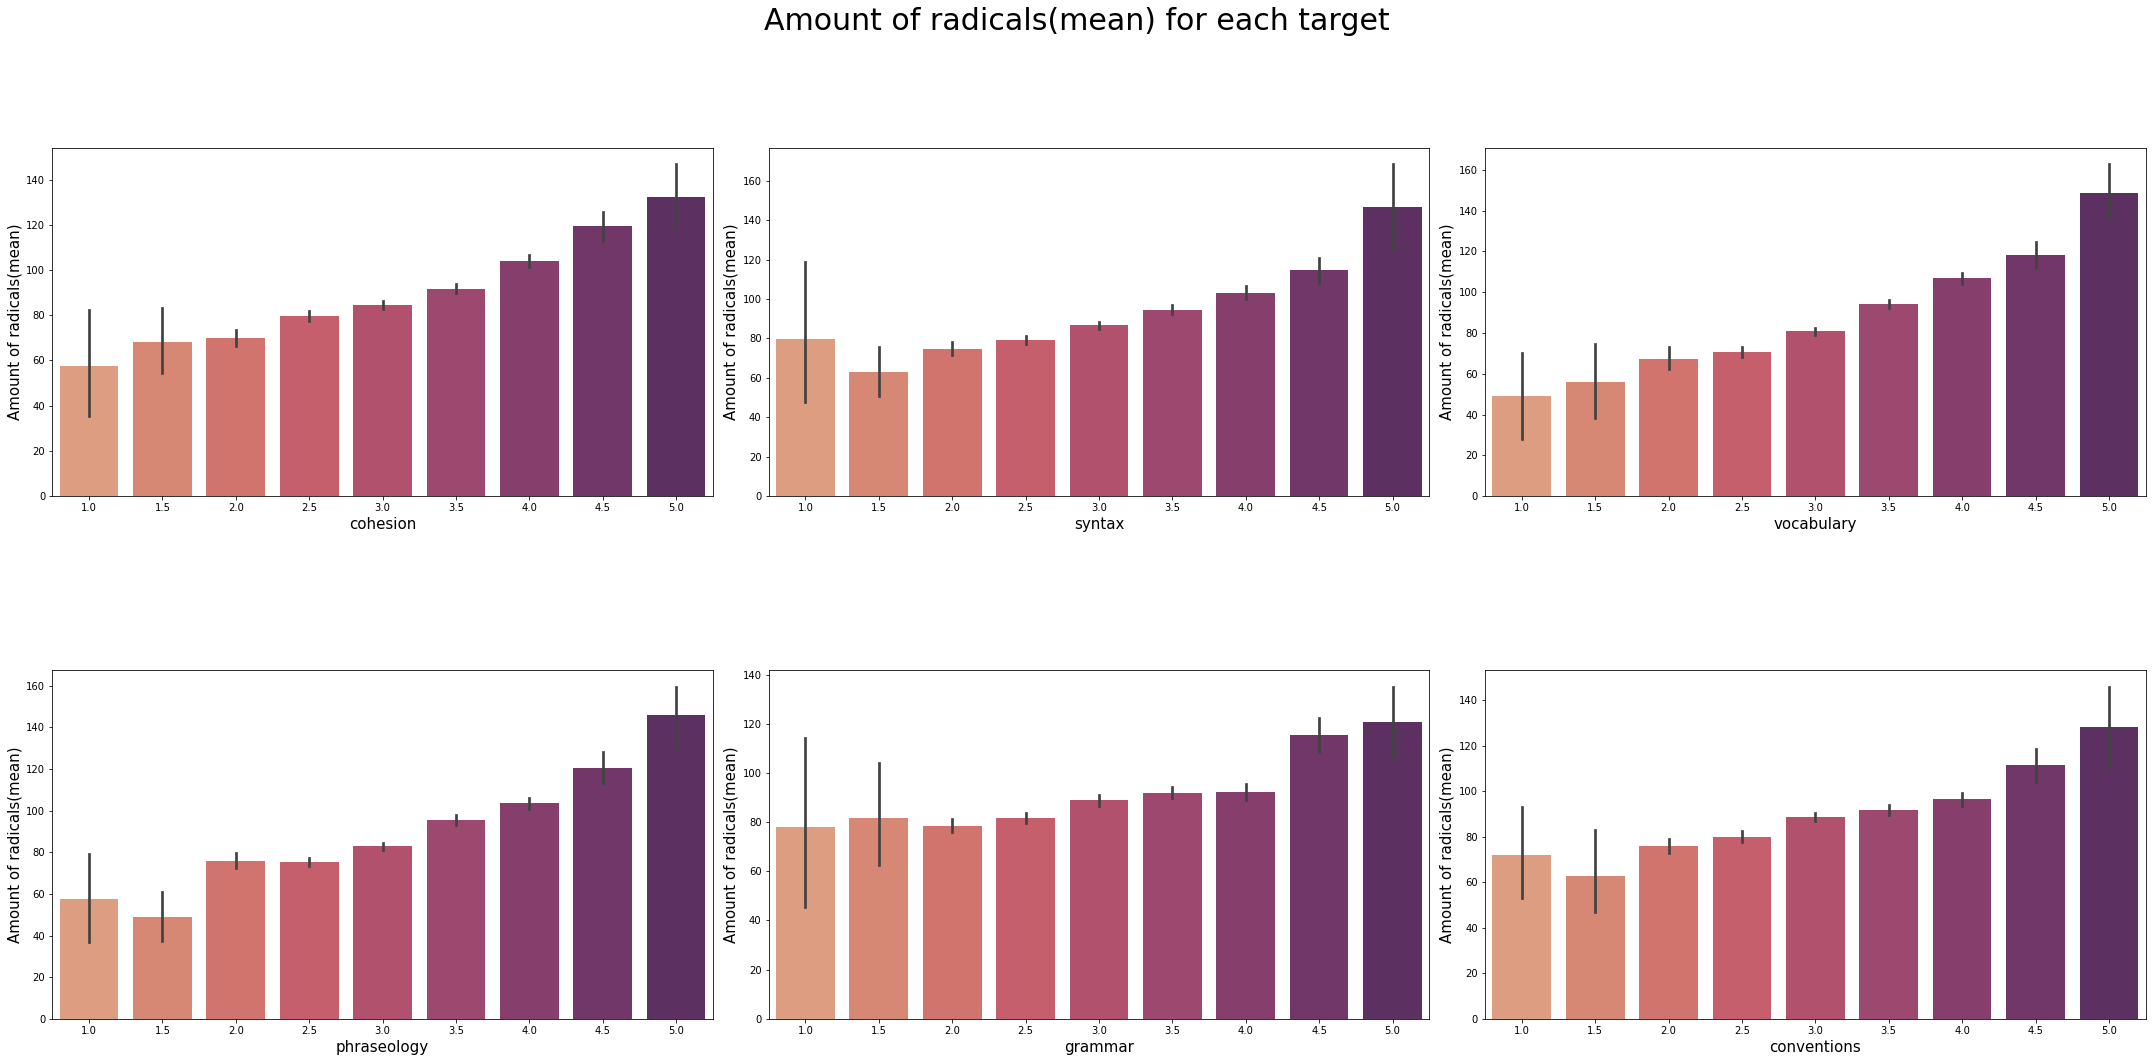

In [28]:
fig,ax =plt.subplots(2,3) 
fig.suptitle("Amount of radicals(mean) for each target",fontsize=30)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]    
target_names=list(y)
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimY)+j
        graph=sns.barplot(data=df_relevant,x=target_names[oneDIndex],y="amt_radicals",palette="flare",ax=ax[i,j])
        ax[i,j].set_xlabel(target_names[oneDIndex],size=15) 
        ax[i,j].set_ylabel("Amount of radicals(mean)",size=15) 
fig.align_labels() 
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5)  

### MAKING HIST OF AMOUNT OF WORDS

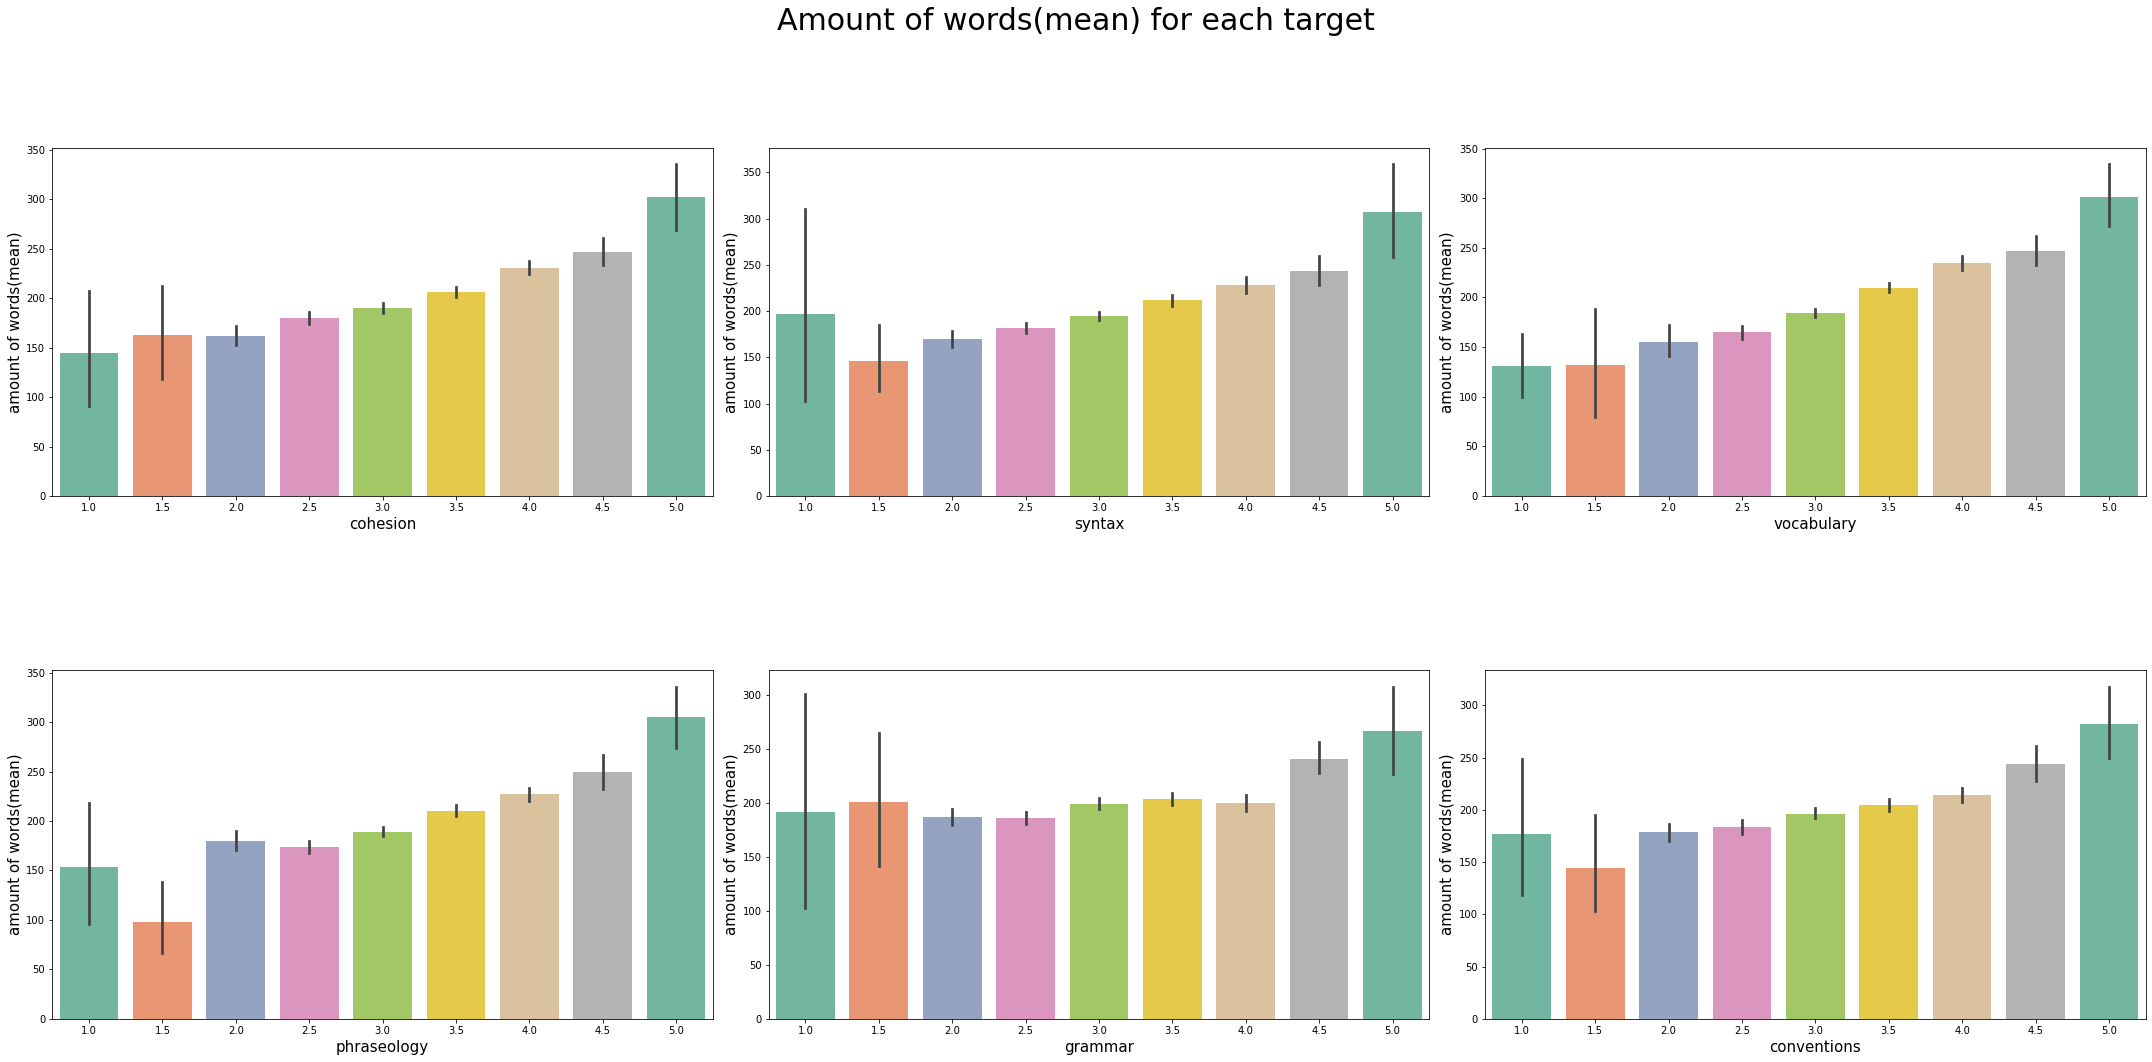

In [29]:
fig,ax =plt.subplots(2,3) 
fig.suptitle("Amount of words(mean) for each target",fontsize=30)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]    
target_names=list(y)
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimY)+j
        graph=sns.barplot(data=df_relevant,x=target_names[oneDIndex],y="n_of_words",palette="Set2",ax=ax[i,j])
        ax[i,j].set_xlabel(target_names[oneDIndex],size=15) 
        ax[i,j].set_ylabel("amount of words(mean)",size=15) 
fig.align_labels() 
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5)  

### MAKING HIST OF AMOUNT OF STOPWORDS

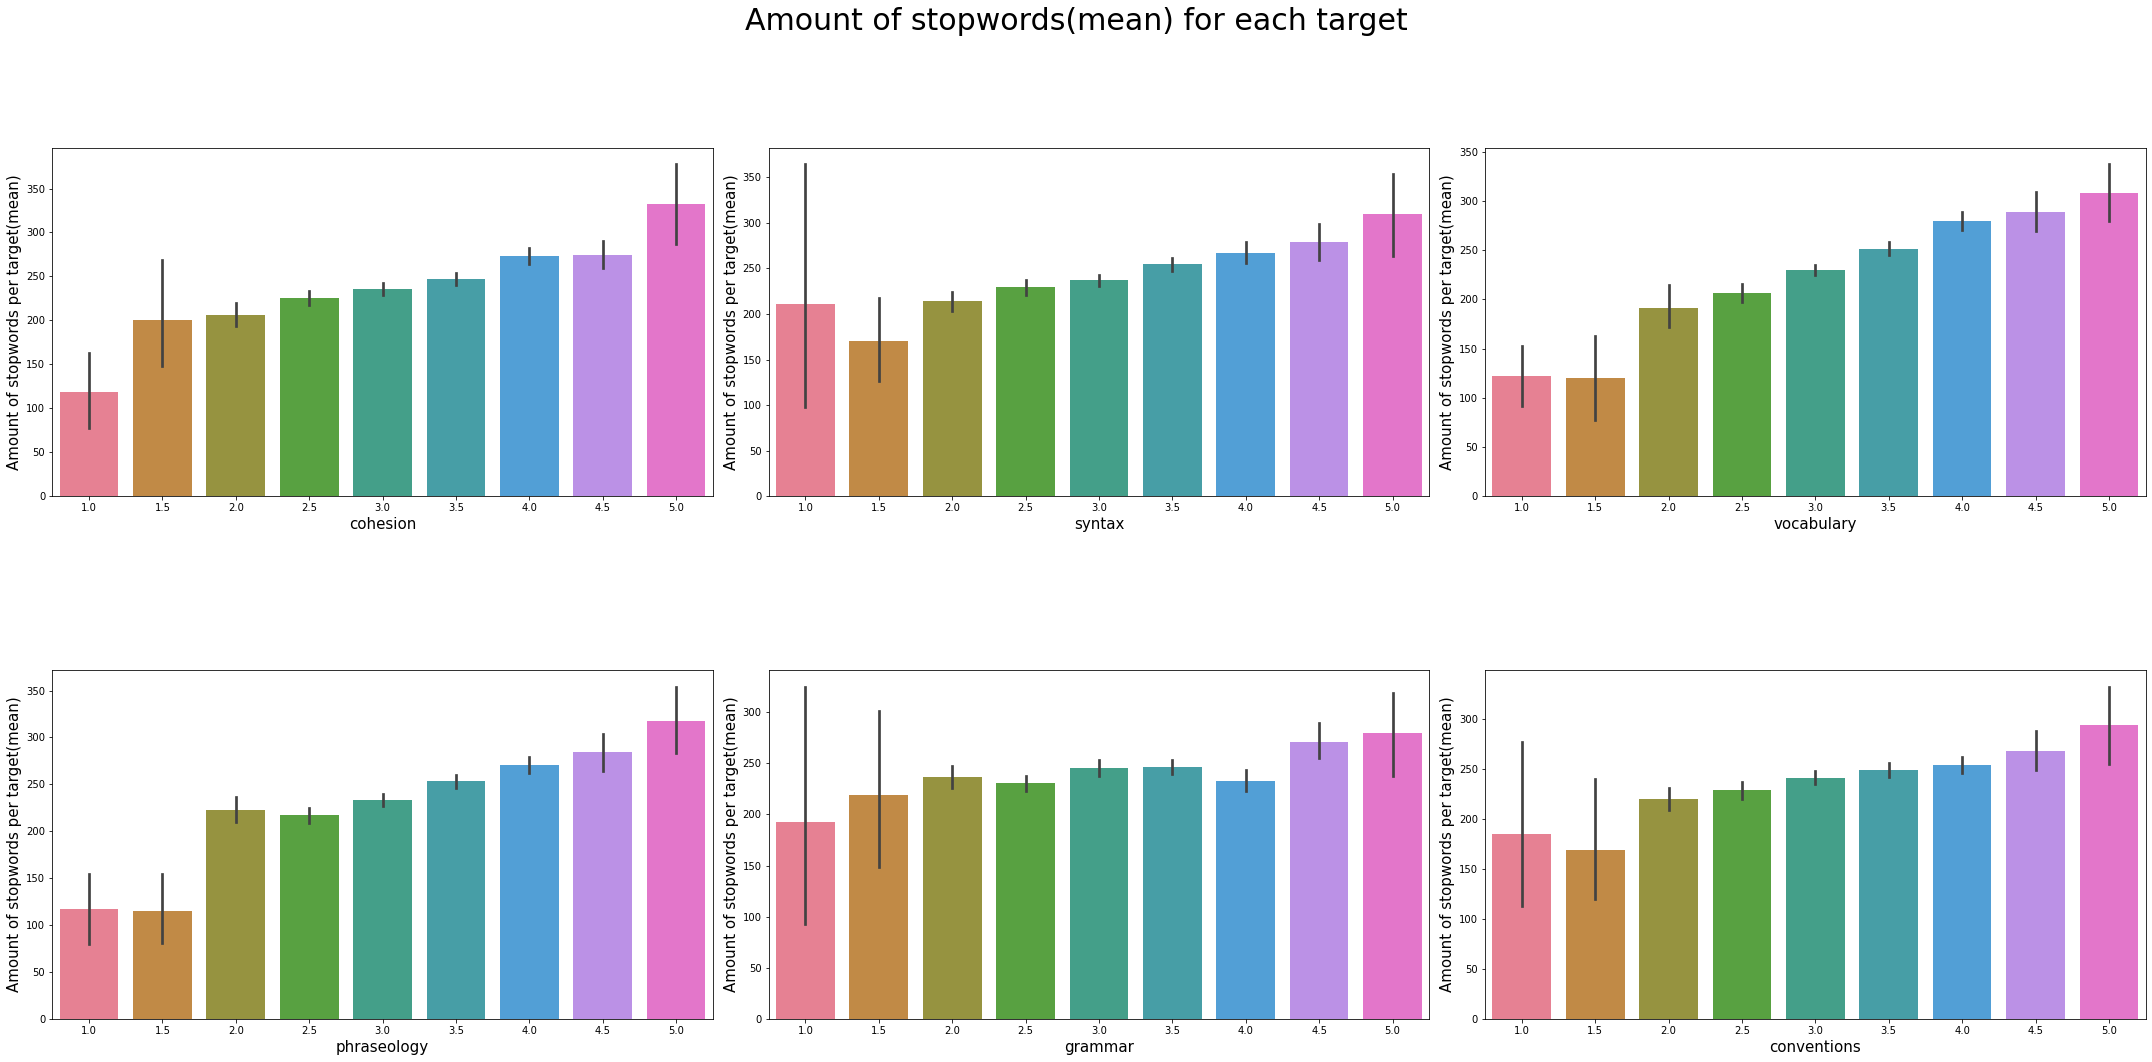

In [30]:
fig,ax =plt.subplots(2,3) 
fig.suptitle("Amount of stopwords(mean) for each target",fontsize=30)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]    
target_names=list(y)
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimY)+j
        graph=sns.barplot(data=df_relevant,x=target_names[oneDIndex],y="amt_stopwords",palette="husl",ax=ax[i,j])
        ax[i,j].set_xlabel(target_names[oneDIndex],size=15) 
        ax[i,j].set_ylabel("Amount of stopwords per target(mean)",size=15) 
fig.align_labels() 
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5)

## SAVING RELEVANT FILE TO CSV

In [31]:
df_relevant.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_of_words,ort_mistakes,amt_radicals,amt_stopwords
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053,197.701867,5.582204,88.028893,240.545641
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450,86.542751,8.247720,34.454573,113.835489
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,0.000000,6.000000,6.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000,135.000000,0.000000,62.000000,161.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,185.000000,2.000000,83.000000,220.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,244.000000,8.000000,107.000000,295.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,579.000000,136.000000,255.000000,853.000000


In [32]:
df_relevant 

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_of_words,most_common_words,ort_mistakes,amt_radicals,amt_stopwords
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,129,"('students', 'go', 'home', 'u', 'wont', 'get',...",1,81,135
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,215,"('change', 'different', 'see', 'understand', '...",0,80,323
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,133,"('average', 'sports', 'school', 'activities', ...",0,56,202
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,282,"('make', 'choices', 'others', 'want', 'people'...",0,125,484
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,112,"('people', 'act', 'change', 'kindess', 'person...",10,58,122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,96,"('believe', 'could', 'using', 'cellphones', 'u...",16,56,83
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,214,"('students', 'work', 'group', 'working', 'get'...",15,98,253
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0,109,"('problem', 'best', 'every', 'get', 'chance', ...",9,59,150
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5,228,"('people', 'others', 'example', 'influence', '...",1,94,294


In [33]:
#df_relevant.to_csv("./relevant/relevant.csv",index=False) 
e_string=df_relevant["full_text"][1540] 
df_relevant.iloc[2389] 

text_id                                                   B1AFACE6704E
full_text            I agree with Michelangelo's statement as I hav...
cohesion                                                           5.0
syntax                                                             5.0
vocabulary                                                         5.0
phraseology                                                        5.0
grammar                                                            5.0
conventions                                                        5.0
n_of_words                                                         457
most_common_words    ('high', 'setting', 'goals', 'aim', 'goal', 'c...
ort_mistakes                                                         4
amt_radicals                                                       155
amt_stopwords                                                      466
Name: 2389, dtype: object

## TRAINING MODEL

In [34]:
df_essays["full_text"] 

0       I think that students would benefit from learn...
1       When a problem is a change you have to let it ...
2       Dear, Principal\n\nIf u change the school poli...
3       The best time in life is when you become yours...
4       Small act of kindness can impact in other peop...
                              ...                        
3906    I believe using cellphones in class for educat...
3907    Working alone, students do not have to argue w...
3908    "A problem is a chance for you to do your best...
3909    Many people disagree with Albert Schweitzer's ...
3910    Do you think that failure is the main thing fo...
Name: full_text, Length: 3911, dtype: object

In [35]:
X=df_relevant.drop(columns=target_names)
X=X.set_index("text_id")   
X=X.drop(columns=["most_common_words"])
X,colnames=transform_to_bag_of_words(X)   
colnames=np.concatenate((colnames,["n_of_words",'ort_mistakes','amt_radicals','amt_stopwords'])) 
X=pd.DataFrame(X,columns=colnames) 
X

c:\Users\Leonardo\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'wont', 'would'] not in stop_words.
  warnings.warn(


,abandoned,abilities,ability,able,abole,aboute,abraham,abroad,absent,absolute,...,youyou,ypu,yuo,zero,zone,zoo,n_of_words,ort_mistakes,amt_radicals,amt_stopwords
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,129,1,81,135
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,215,0,80,323
2,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,133,0,56,202
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,282,0,125,484
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,112,10,58,122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,96,16,56,83
3907,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,214,15,98,253
3908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,109,9,59,150
3909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,228,1,94,294


In [36]:
df_relevant

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_of_words,most_common_words,ort_mistakes,amt_radicals,amt_stopwords
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,129,"('students', 'go', 'home', 'u', 'wont', 'get',...",1,81,135
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,215,"('change', 'different', 'see', 'understand', '...",0,80,323
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,133,"('average', 'sports', 'school', 'activities', ...",0,56,202
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,282,"('make', 'choices', 'others', 'want', 'people'...",0,125,484
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,112,"('people', 'act', 'change', 'kindess', 'person...",10,58,122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,96,"('believe', 'could', 'using', 'cellphones', 'u...",16,56,83
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,214,"('students', 'work', 'group', 'working', 'get'...",15,98,253
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0,109,"('problem', 'best', 'every', 'get', 'chance', ...",9,59,150
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5,228,"('people', 'others', 'example', 'influence', '...",1,94,294


In [37]:
""" print(type(X)) 
print(type(transform_to_bag_of_words(df_essays['full_text']))) 
vectorizer=CountVectorizer(tokenizer=filter_text,dtype=np.dtype.kind) 
print(type(vectorizer.fit_transform(df_essays['full_text']).toarray())) """

" print(type(X)) \nprint(type(transform_to_bag_of_words(df_essays['full_text']))) \nvectorizer=CountVectorizer(tokenizer=filter_text,dtype=np.dtype.kind) \nprint(type(vectorizer.fit_transform(df_essays['full_text']).toarray())) "

In [1]:
def getModels(): 
   return {"LINEAR REGRESSION":MultiOutputRegressor(LinearRegression()), 
    "RANDOM FOREST":MultiOutputRegressor(RandomForestRegressor()),
    "ADA BOOST":MultiOutputRegressor(AdaBoostRegressor()), 
    "DECISION TREE":MultiOutputRegressor(DecisionTreeRegressor()), 
    "SGD":MultiOutputRegressor(make_pipeline(StandardScaler(),SGDRegressor(max_iter=1000, tol=1e-3))), 
    "KNN":MultiOutputRegressor(KNeighborsRegressor()),
    "RNN":MultiOutputRegressor(RadiusNeighborsRegressor()),
    "EXTRA TREES":MultiOutputRegressor(ExtraTreesRegressor(random_state=0,max_depth=6)),
    "GRADIENT BOOST":MultiOutputRegressor(GradientBoostingRegressor(random_state=0))}

In [2]:
models=getModels() 
scores={}
""" for i in models.keys(): 
    scores[i]=cross_val_score(models[i],X,y,cv=10,n_jobs=-1) """

scores['RANDOM FOREST']=cross_val_score(models['RANDOM FOREST'],X,y,cv=10,)

scores

NameError: name 'MultiOutputRegressor' is not defined

In [ ]:
predictions= cross_val_predict(models['RANDOM FOREST'],X,y,cv=10,n_jobs=6)

NameError: name 'cross_val_predict' is not defined

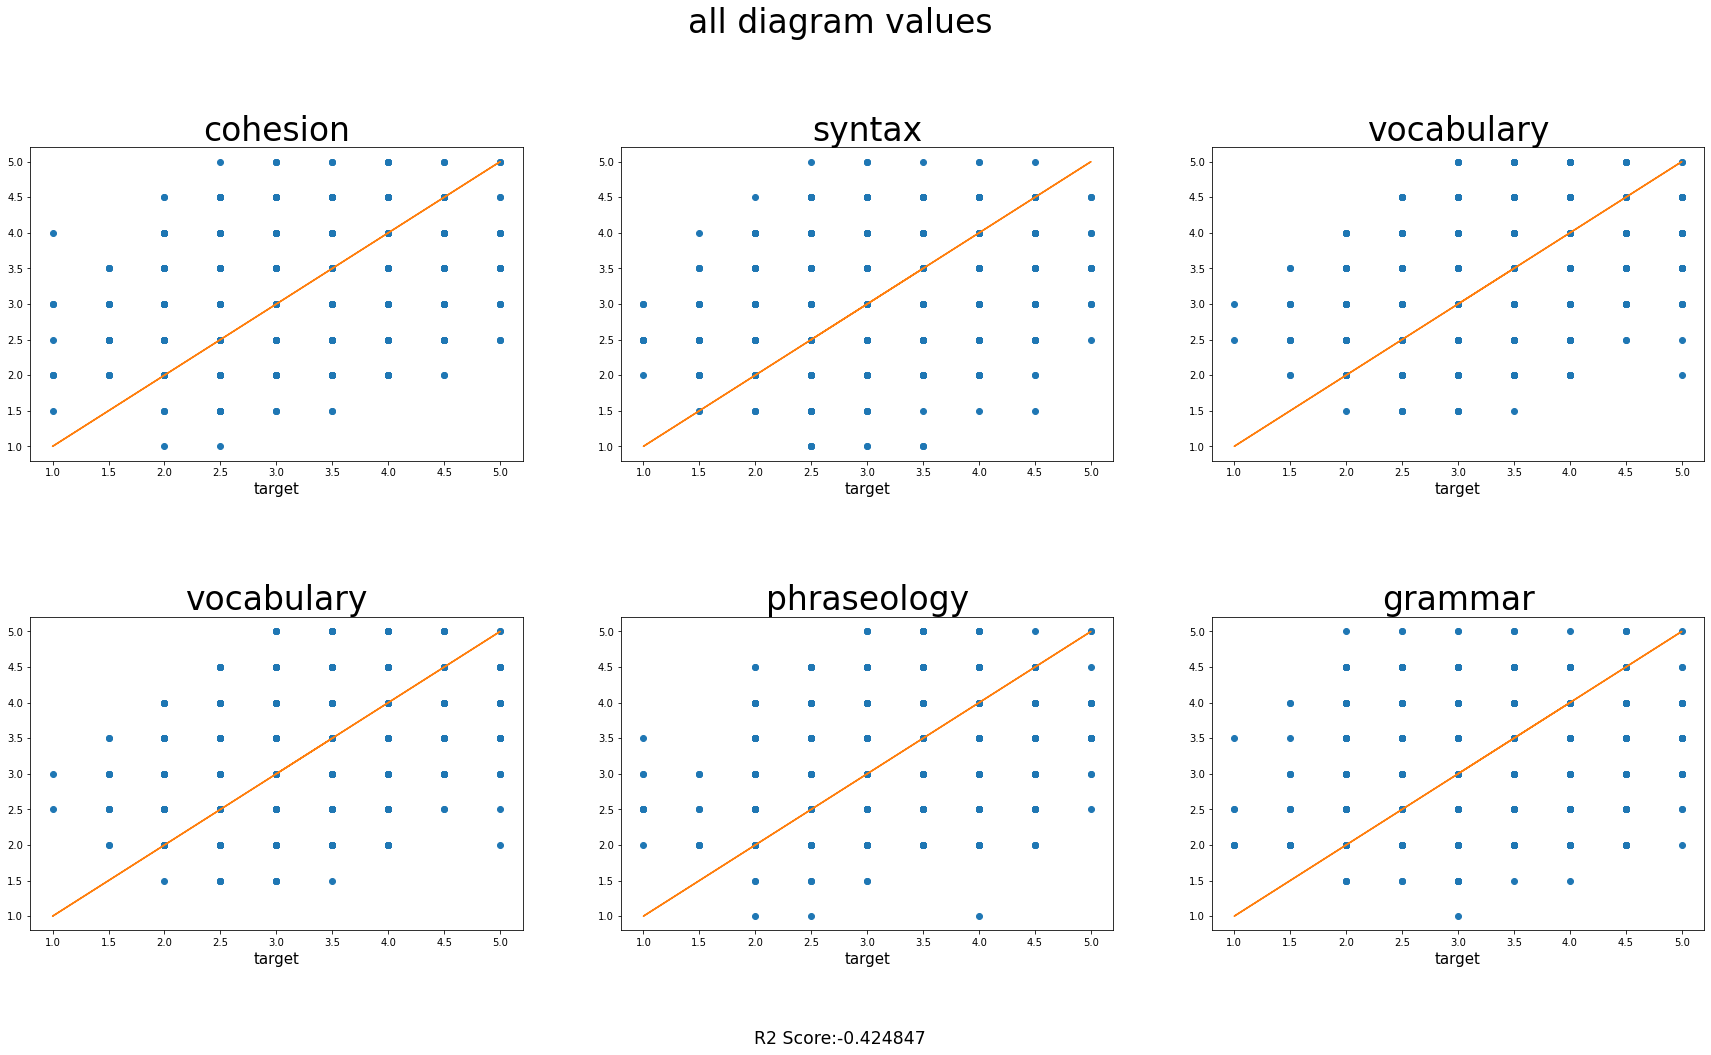

In [ ]:
#predictions["target"]=y  
arrs=[
    (["Pred"] *6)+(["Real"] * 6),
    target_names.copy() + target_names.copy()
]  
scaler=StandardScaler()
tarrs=zip(arrs[0],arrs[1])
predictions_index=pd.MultiIndex.from_tuples(tarrs) 
pred_and_y=np.concatenate((predictions,y.to_numpy()),axis=1)
compares=pd.DataFrame(pred_and_y,columns=predictions_index) 
#print(predictions)
#predictions=np.transpose(pd.DataFrame(predictions)) 
fig,ax =plt.subplots(2,3) 
fig.suptitle("all diagram values",size=33)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]   
r2=r2_score(y,predictions,multioutput='uniform_average') 
fig.text(0.5,0.02,"R2 Score:%f"%r2,fontsize="xx-large",ha='center')
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimX)+j
        ax[i,j].plot(compares['Real'][target_names[oneDIndex]],compares['Pred'][target_names[oneDIndex]],"o")  
        ax[i,j].set_title(target_names[oneDIndex],size=33) 
        ax[i,j].set_xlabel("target",size=15) 
        #ax[i,j].set_xbound(lower=0,upper=350)  
        m,b=np.polyfit(y[target_names[oneDIndex]],y[target_names[oneDIndex]],deg=1)
        ax[i,j].plot(y[target_names[oneDIndex]],m*y[target_names[oneDIndex]]+b)
        #centerish=ax[i,j].get_xbound()[1]/2
        #centerishY=ax[i,j].get_ybound()[1]/2
        #ax[i,j].text(x=centerish-13,y=-centerishY/2.5,s=("R2:%f" % float(auxdic[oneDIndex][1])),ma="center")
fig.align_labels() 
fig.subplots_adjust(top=0.85,hspace=0.5) 

### one hot encoding it

In [ ]:
compares

Pred                                                       Real  \
     cohesion syntax vocabulary phraseology grammar conventions cohesion   
0         3.0    3.0        3.5         3.5     3.0         3.5      3.5   
1         3.0    3.5        4.0         2.5     2.0         3.0      2.5   
2         2.5    3.0        3.5         2.5     2.5         2.5      3.0   
3         3.5    2.5        3.0         4.0     2.0         3.0      4.5   
4         4.0    3.0        2.5         3.0     3.0         3.5      2.5   
...       ...    ...        ...         ...     ...         ...      ...   
3906      3.0    2.5        2.5         2.0     4.0         2.0      2.5   
3907      3.5    4.0        4.0         3.0     3.0         3.0      4.0   
3908      3.5    2.5        3.0         2.5     2.5         2.5      2.5   
3909      2.5    2.5        3.0         2.0     3.0         3.0      4.0   
3910      3.5    2.0        4.0         3.5     3.5         2.5      3.5   

                                                        
     syntax vocabulary phraseology grammar conventions  
0       3.5        3.0         3.0     4.0         3.0  
1       2.5        3.0         2.0     2.0         2.5  
2       3.5        3.0         3.0     3.0         2.5  
3       4.5        4.5         4.5     4.0         5.0  
4       3.0        3.0         3.0     2.5         2.5  
...     ...        ...         ...     ...         ...  
3906    3.0        3.0         3.5     2.5         2.5  
3907    4.0        4.0         4.0     3.5         3.0  
3908    3.0        3.0         3.0     3.5         3.0  
3909    4.5        4.5         4.0     4.5         4.5  
3910    2.5        3.5         3.0     3.0         3.5  

[3911 rows x 12 columns]

## Running time

In [ ]:
end=time.time() 
print(end-start)

1137.4901204109192
